<a href="https://colab.research.google.com/github/zierenberg/machine_learning_muca/blob/MW/double_well_minimal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
!git clone https://github.com/zierenberg/machine_learning_muca.git

fatal: destination path 'machine_learning_muca' already exists and is not an empty directory.


In [92]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf
import sys

In [93]:
class DoubleWell(object):

    params_default = {'a4' : 1.0,
                      'a2' : 6.0,
                      'a1' : 1.0,
                      'k' : 1.0,
                      'dim' : 1}

    def __init__(self, params=None):
        # set parameters
        if params is None:
            params = self.__class__.params_default
        self.params = params

        # useful variables
        self.dim = self.params['dim']


    def energy(self, x):
        dimer_energy =self.params['a4'] * x[:, 0] ** 4 - self.params['a2'] * x[:, 0] ** 2 + self.params['a1'] * x[:, 0]
        oscillator_energy = 0.0
        if self.dim == 2:
            oscillator_energy = (self.params['k'] / 2.0) * x[:, 1] ** 2
        if self.dim > 2:
            oscillator_energy = np.sum((self.params['k'] / 2.0) * x[:, 1:] ** 2, axis=1)
        return  dimer_energy + oscillator_energy

    def energy_tf(self, x):
        dimer_energy =self.params['a4'] * x[:, 0] ** 4 - self.params['a2'] * x[:, 0] ** 2 + self.params['a1'] * x[:, 0]
        oscillator_energy = 0.0
        if self.dim == 2:
            oscillator_energy = (self.params['k'] / 2.0) * x[:, 1] ** 2
        if self.dim > 2:
            oscillator_energy = tf.reduce_sum(input_tensor=(self.params['k'] / 2.0) * x[:, 1:] ** 2, axis=1)
        return  dimer_energy + oscillator_energy

    def plot_dimer_energy(self, axis=None, temperature=1.0):
        """ Plots the dimer energy to the standard figure """
        x_grid = np.linspace(-3, 3, num=200)
        if self.dim == 1:
            X = x_grid[:, None]
        else:
            X = np.hstack([x_grid[:, None], np.zeros((x_grid.size, self.dim - 1))])
        energies = self.energy(X) / temperature

        import matplotlib.pyplot as plt
        if axis is None:
            axis = plt.gca()
        #plt.figure(figsize=(5, 4))
        axis.plot(x_grid, energies, linewidth=3, color='black')
        axis.set_xlabel('x / a.u.')
        axis.set_ylabel('Energy / kT')
        axis.set_ylim(energies.min() - 2.0, energies[int(energies.size / 2)] + 2.0)

        return x_grid, energies

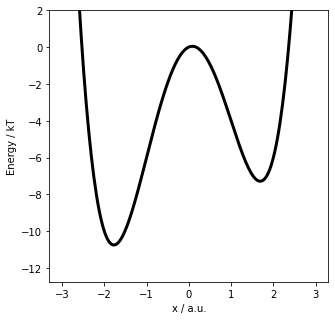

In [94]:
params = DoubleWell.params_default.copy()
params['dim'] =2
double_well = DoubleWell(params=params)
plt.figure(figsize=(5,5))
double_well.plot_dimer_energy();

In [95]:
class MetropolisGauss(object):

    def __init__(self, model, x0, temperature=1.0, noise=0.1,
                 burnin=0, stride=1, nwalkers=1, mapper=None):
        """ Metropolis Monte-Carlo Simulation with Gaussian Proposal Steps

        Parameters
        ----------
        model : Energy model
            Energy model object, must provide the function energy(x)
        x0 : [array]
            Initial configuration
        noise : float
            Noise intensity, standard deviation of Gaussian proposal step
        temperatures : float or array
            Temperature. By default (1.0) the energy is interpreted in reduced units.
            When given an array, its length must correspond to nwalkers, then the walkers
            are simulated at different temperatures.
        burnin : int
            Number of burn-in steps that will not be saved
        stride : int
            Every so many steps will be saved
        nwalkers : int
            Number of parallel walkers
        mapper : Mapper object
            Object with function map(X), e.g. to remove permutation.
            If given will be applied to each accepted configuration.

        """
        self.model = model
        self.noise = noise
        self.temperature = temperature
        self.burnin = burnin
        self.stride = stride
        self.nwalkers = nwalkers
        if mapper is None:
            class DummyMapper(object):
                def map(self, X):
                    return X
            mapper = DummyMapper()
        self.mapper = mapper
        self.reset(x0)

    def _proposal_step(self):
        # proposal step
        self.x_prop = self.x + self.noise*np.random.randn(self.x.shape[0], self.x.shape[1])
        self.x_prop = self.mapper.map(self.x_prop)
        self.E_prop = self.model.energy(self.x_prop)

    def _acceptance_step(self):
        # acceptance step
        acc = -np.log(np.random.rand()) > (self.E_prop - self.E) / self.temperature
        self.x = np.where(acc[:, None], self.x_prop, self.x)
        self.E = np.where(acc, self.E_prop, self.E)

    def reset(self, x0):
        # counters
        self.step = 0
        self.traj_ = []
        self.etraj_ = []

        # initial configuration
        self.x = np.tile(x0, (self.nwalkers, 1))
        self.x = self.mapper.map(self.x)
        self.E = self.model.energy(self.x)

        # save first frame if no burnin
        if self.burnin == 0:
            self.traj_.append(self.x)
            self.etraj_.append(self.E)

    @property
    def trajs(self):
        """ Returns a list of trajectories, one trajectory for each walker """
        T = np.array(self.traj_).astype(np.float32)
        return [T[:, i, :] for i in range(T.shape[1])]

    @property
    def traj(self):
        return self.trajs[0]

    @property
    def etrajs(self):
        """ Returns a list of energy trajectories, one trajectory for each walker """
        E = np.array(self.etraj_)
        return [E[:, i] for i in range(E.shape[1])]

    @property
    def etraj(self):
        return self.etrajs[0]

    def run(self, nsteps=1, verbose=0):
        for i in range(nsteps):
            self._proposal_step()
            self._acceptance_step()
            self.step += 1
            if verbose > 0 and i % verbose == 0:
                print('Step', i, '/', nsteps)
            if self.step > self.burnin and self.step % self.stride == 0:
                self.traj_.append(self.x)
                self.etraj_.append(self.E)

In [96]:
nsteps = 10000
x0_left = np.array([[-1.8, 0.0]])
x0_right = np.array([[1.8, 0.0]])

sampler = MetropolisGauss(double_well, x0_left, noise=0.1, stride=10)
sampler.run(nsteps)
traj_left = sampler.traj.copy()

sampler.reset(x0_left)
sampler.run(nsteps)
traj_left_val = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right_val = sampler.traj.copy()

Text(0.5, 0, 'Probability')

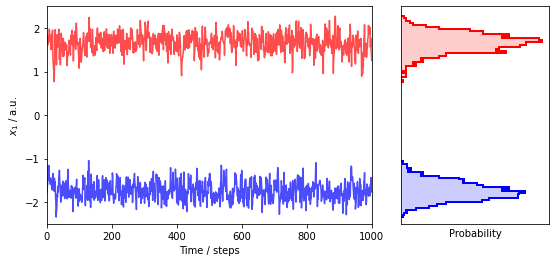

In [97]:
plt.figure(figsize=(9, 4))
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 3), (0, 2))
ax1.plot(traj_left[:, 0], color='blue', alpha=0.7)
ax1.plot(traj_right[:, 0], color='red', alpha=0.7)
ax1.set_xlim(0, 1000)
ax1.set_ylim(-2.5, 2.5)
ax1.set_xlabel('Time / steps')
ax1.set_ylabel('$x_1$ / a.u.')
ax2.hist(traj_left[:, 0], 30, orientation='horizontal', histtype='stepfilled', color='blue', alpha=0.2);
ax2.hist(traj_left[:, 0], 30, orientation='horizontal', histtype='step', color='blue', linewidth=2);
ax2.hist(traj_right[:, 0], 30, orientation='horizontal', histtype='stepfilled', color='red', alpha=0.2);
ax2.hist(traj_right[:, 0], 30, orientation='horizontal', histtype='step', color='red', linewidth=2);
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylim(-2.5, 2.5)
ax2.set_xlabel('Probability')

In [98]:
x = np.vstack([traj_left, traj_right])
xval = np.vstack([traj_left_val, traj_right_val])

In [99]:
# util.py

def ensure_traj(X):
    if np.ndim(X) == 2:
        return X
    if np.ndim(X) == 1:
        return np.array([X])
    raise ValueError('Incompatible array with shape: ', np.shape(X))

def connect(input_layer, layers):
    """ Connect the given sequence of layers and returns output layer

    Parameters
    ----------
    input_layer : keras layer
        Input layer
    layers : list of keras layers
        Layers to be connected sequentially

    Returns
    -------
    output_layer : kears layer
        Output Layer

    """
    layer = input_layer
    for l in layers:
        layer = l(layer)
    return layer

def linlogcut(x, a=0, b=1000, tf=False):
    """ Function which is linear until a, logarithmic until b and then constant.

    y = x                  x <= a
    y = a + log(x-a)   a < x < b
    y = a + log(b-a)   b < x

    """
    if tf:
        return _linlogcut_tf(x, a=a, b=b)
    else:
        return _linlogcut_np(x, a=a, b=b)

def _linlogcut_tf(x, a=0, b=1000):
    # cutoff x after b - this should also cutoff infinities
    x = tf.compat.v1.where(x < b, x, b * tf.ones(tf.shape(input=x)))
    # log after a
    y = a + tf.compat.v1.where(x < a, x - a, tf.math.log(x - a + 1))
    # make sure everything is finite
    y = tf.compat.v1.where(tf.math.is_finite(y), y, b * tf.ones(tf.shape(input=y)))
    return y

def _linlogcut_tf_constantclip(x, a=0, b=1000):
    # cutoff x after b - this should also cutoff infinities
    x = tf.compat.v1.where(x < b, x, x / tf.maximum(1., tf.stop_gradient(x) / b))
    # cutoff x after b - this should also cutoff infinities
    #x = tf.where(x < b, x, b * tf.ones(tf.shape(x)))
    # log after a
    y = a + tf.compat.v1.where(x < a, x - a, tf.math.log(x - a + 1))
    # make sure everything is finite
    y = tf.compat.v1.where(tf.math.is_finite(y), y, b * tf.ones(tf.shape(input=y)))
    return y

def _linlogcut_np(x, a=0, b=1000):
    raise NotImplementedError('Numpy version not yet implemented.')

In [100]:
# layers_basic.py

import numbers

def nonlinear_transform(output_size, nlayers=3, nhidden=100, activation='relu', init_outputs=None, **args):
    """ Generic dense trainable nonlinear transform

    Returns the layers of a dense feedforward network with nlayers-1 hidden layers with nhidden neurons
    and the specified activation functions. The last layer is linear in order to access the full real
    number range and has output_size output neurons.

    Parameters
    ----------
    output_size : int
        number of output neurons
    nlayers : int
        number of layers, including the linear output layer. nlayers=3 means two hidden layers with
        nonlinear activation and one linear output layer.
    nhidden : int
        number of neurons in each hidden layer, either a number or an array of length nlayers-1
        to specify the width of each hidden layer
    activation : str
        nonlinear activation function in hidden layers
    init_outputs : None or float or array
        None means default initialization for the output layer, otherwise it is currently initialized with 0
    **args : kwargs
        Additional keyword arguments passed to the layer

    """
    if isinstance(nhidden, numbers.Integral):
        nhidden = nhidden * np.ones(nlayers-1, dtype=int)
    else:
        nhidden = np.array(nhidden)
        if nhidden.size != nlayers-1:
            raise ValueError('Illegal size of nhidden. Expecting 1d array with nlayers-1 elements')
    M = [keras.layers.Dense(nh, activation=activation, **args) for nh in nhidden]
    if init_outputs is None:
        final_layer = keras.layers.Dense(output_size, activation='linear', **args)
    else:
        argscopy = copy.deepcopy(args)
        argscopy['kernel_initializer'] = keras.initializers.Zeros()
        argscopy['bias_initializer'] = keras.initializers.Constant(init_outputs)
        final_layer = keras.layers.Dense(output_size, activation='linear', **argscopy)
                                         #kernel_initializer=keras.initializers.Zeros(),
                                         #bias_initializer=keras.initializers.Constant(init_outputs))
    M += [final_layer]

    return M


class ResampleLayer(keras.engine.Layer):
    """
    Receives as inputs latent space encodings z and normal noise w. Transforms w to
    Match the mean and the standard deviations of z.

    """
    def __init__(self, dim, **kwargs):
        self.dim = dim
        super(ResampleLayer, self).__init__(**kwargs)

    def call(self, x):
        # split input into latent and noise variables
        z = x[:, :self.dim]
        w = x[:, self.dim:]
        #z, w = x
        # mean
        mean = keras.backend.mean(z, axis=0)
        # covariance matrix
        batchsize = keras.backend.shape(z)[0]
        cov = keras.backend.dot(keras.backend.transpose(z), z) / keras.backend.cast(batchsize, np.float32)
        # standard deviations
        std = tf.sqrt(tf.linalg.tensor_diag_part(cov))
        # transform w and return
        wtrans = tf.reshape(mean, (1, self.dim)) + w * tf.reshape(std, (1, self.dim))
        return wtrans

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.dim


class IndexLayer(keras.engine.Layer):
    def __init__(self, indices, **kwargs):
        """ Returns [:, indices].
        """
        self.indices = indices
        super().__init__(**kwargs)

    def call(self, x):
        # split input
        return tf.gather(x, self.indices, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.indices.size

In [101]:
# invertible_layers.py

def split_merge_indices(ndim, nchannels=2, channels=None):
    if channels is None:
        channels = np.tile(np.arange(nchannels), int(ndim/nchannels)+1)[:ndim]
    else:
        channels = np.array(channels)
        nchannels = np.max(channels) + 1
    indices_split = []
    idx = np.arange(ndim)
    for c in range(nchannels):
        isplit = np.where(channels == c)[0]
        indices_split.append(isplit)
    indices_merge = np.concatenate(indices_split).argsort()
    return channels, indices_split, indices_merge

class Permute(object):
    def __init__(self, ndim, order=None):
        """ Permutes dimensions

        Parameters:
        -----------
        order : None or array
            If None, a random permutation will be chosen.
            Otherwise, specify the new order of dimensions for x -> z.

        """
        self.ndim = ndim
        if order is None:
            order = np.random.choice(ndim, ndim, replace=False)
        self.order = order
        self.reverse = np.argsort(order)

    @classmethod
    def from_dict(cls, D):
        ndim = D['ndim']
        order = D['order']
        return cls(ndim, order=order)

    def to_dict(self):
        D = {}
        D['ndim'] = self.ndim
        D['order'] = self.order
        return D

    def connect_xz(self, x):
        self.output_z = IndexLayer(self.order)(x)
        return self.output_z

    def connect_zx(self, z):
        self.output_x = IndexLayer(self.reverse)(z)
        return self.output_x


class SplitChannels(object):
    def __init__(self, ndim, nchannels=2, channels=None):
        """ Splits channels forward and merges them backward """
        self.channels, self.indices_split, self.indices_merge = split_merge_indices(ndim, nchannels=nchannels,
                                                                                    channels=channels)

    @classmethod
    def from_dict(cls, D):
        channels = D['channels']
        dim = channels.size
        nchannels = channels.max() + 1
        return cls(dim, nchannels=nchannels, channels=channels)

    def to_dict(self):
        D = {}
        D['channels'] = self.channels
        return D

    def connect_xz(self, x):
        # split X into different coordinate channels
        self.output_z = [IndexLayer(isplit)(x) for isplit in self.indices_split]
        return self.output_z

    def connect_zx(self, z):
        # first concatenate
        x_scrambled = keras.layers.Concatenate()(z)
        # unscramble x
        self.output_x = IndexLayer(self.indices_merge)(x_scrambled) # , name='output_x'
        return self.output_x


class MergeChannels(SplitChannels):
    def connect_xz(self, x):
        # first concatenate
        z_scrambled = keras.layers.Concatenate()(x)
        # unscramble x
        self.output_z = IndexLayer(self.indices_merge)(z_scrambled) # , name='output_z'
        return self.output_z

    def connect_zx(self, z):
        # split X into different coordinate channels
        self.output_x = [IndexLayer(isplit)(z) for isplit in self.indices_split]
        return self.output_x


class Scaling(object):
    def __init__(self, ndim, scaling_factors=None, trainable=True, name_xz=None, name_zx=None):
        """ Invertible Scaling layer

        Parameters
        ----------
        ndim : int
            Number of dimensions
        scaling_factors : array
            Initial scaling factors, must be of shape (1, ndim)
        trainable : bool
            If True, scaling factors are trainable. If false, they are fixed
        name_xz : str
            Name for Sxz
        name_xz : str
            Name for Szx

        """
        # define local classes
        class ScalingLayer(keras.engine.Layer):
            def __init__(self, log_scaling_factors, **kwargs):
                """ Layer that scales dimensions with trainable factors

                Parameters
                ----------
                scaling_factors : (1xd) array
                    scaling factors applied to columns of batch matrix.

                """
                self.log_scaling_factors = log_scaling_factors
                super().__init__(**kwargs)

            def build(self, input_shape):
                # Make weight trainable
                if self.trainable:
                    self._trainable_weights.append(self.log_scaling_factors)
                super().build(input_shape)  # Be sure to call this at the end

            def compute_output_shape(self, input_shape):
                return (input_shape[0], self.log_scaling_factors.shape[1])

        class ScalingXZ(ScalingLayer):
            def __init__(self, log_scaling_factors, **kwargs):
                """ Layer that scales the batch X in (B,d) by X * S where S=diag(s1,...,sd)
                """
                super().__init__(log_scaling_factors, **kwargs)

            def call(self, x):
                return x * tf.exp(self.log_scaling_factors)

        class ScalingZX(ScalingLayer):
            def __init__(self, log_scaling_factors, **kwargs):
                """ Layer that scales the batch X in (B,d) by X * S^(-1) where S=diag(s1,...,sd)
                """
                super().__init__(log_scaling_factors, **kwargs)

            def call(self, x):
                return x * tf.exp(-self.log_scaling_factors)

        # initialize scaling factors
        if scaling_factors is None:
            self.log_scaling_factors = keras.backend.variable(np.zeros((1, ndim)),
                                                              dtype=keras.backend.floatx(),
                                                              name='log_scale')
        else:
            self.log_scaling_factors = keras.backend.variable(np.log(scaling_factors),
                                                              dtype=keras.backend.floatx(),
                                                              name='log_scale')

        self.trainable = trainable
        self.Sxz = ScalingXZ(self.log_scaling_factors, trainable=trainable, name=name_xz)
        self.Szx = ScalingZX(self.log_scaling_factors, trainable=trainable, name=name_zx)

    @property
    def scaling_factors(self):
        return tf.exp(self.log_scaling_factors)

    @classmethod
    def from_dict(cls, D):
        scaling_factors = D['scaling_factors']
        dim = scaling_factors.shape[1]
        trainable = D['trainable']
        name_xz = D['name_xz']
        name_zx = D['name_zx']
        return Scaling(dim, scaling_factors=scaling_factors, trainable=trainable, name_xz=name_xz, name_zx=name_zx)

    def to_dict(self):
        D = {}
        D['scaling_factors'] = keras.backend.eval(self.scaling_factors)
        D['trainable'] = self.trainable
        D['name_xz'] = self.Sxz.name
        D['name_zx'] = self.Szx.name
        return D

    def connect_xz(self, x):
        def lambda_Jxz(x):
            J = tf.reduce_sum(input_tensor=self.log_scaling_factors, axis=1)[0]
            return J * keras.backend.ones((tf.shape(input=x)[0], 1))
        self.log_det_xz = keras.layers.Lambda(lambda_Jxz)(x)
        z = self.Sxz(x)
        return z

    def connect_zx(self, z):
        def lambda_Jzx(x):
            J = tf.reduce_sum(input_tensor=-self.log_scaling_factors, axis=1)[0]
            return J * keras.backend.ones((tf.shape(input=x)[0], 1))
        self.log_det_zx = keras.layers.Lambda(lambda_Jzx)(z)
        x = self.Szx(z)
        return x

    @property
    def log_det_Jxz(self):
        """ Log of |det(dz/dx)| for the current batch. Format is batchsize x 1 or a number """
        return self.log_det_xz

    @property
    def log_det_Jzx(self):
        """ Log of |det(dx/dz)| for the current batch. Format is batchsize x 1 or a number """
        return self.log_det_zx


class CompositeLayer(object):
    def __init__(self, transforms):
        """ Composite layer consisting of multiple keras layers with shared parameters  """
        self.transforms = transforms

    @classmethod
    def from_dict(cls, d):
        from deep_boltzmann.networks.util import deserialize_layers
        transforms = deserialize_layers(d['transforms'])
        return cls(transforms)

    def to_dict(self):
        from deep_boltzmann.networks.util import serialize_layers
        D = {}
        D['transforms'] = serialize_layers(self.transforms)
        return D


class NICER(CompositeLayer):
    def __init__(self, transforms):
        """ Two sequential NICE transformations and their inverse transformations.

        Parameters
        ----------
        transforms : list
            List with [M1, M2] containing the keras layers for nonlinear transformation 1 and 2.

        """
        super().__init__(transforms)
        self.M1 = transforms[0]
        self.M2 = transforms[1]

    def connect_xz(self, x):
        x1 = x[0]
        x2 = x[1]
        self.input_x1 = x1
        self.input_x2 = x2

        # first stage backward
        y2 = x2
        y1 = keras.layers.Subtract()([x1, connect(x2, self.M2)])
        # second stage backward
        z1 = y1
        z2 = keras.layers.Subtract()([y2, connect(y1, self.M1)])

        return [z1, z2] + x[2:]  # append other layers if there are any

    def connect_zx(self, z):
        z1 = z[0]
        z2 = z[1]
        self.input_z1 = z1
        self.input_z2 = z2

        # first stage forward
        y1 = z1
        y2 = keras.layers.Add()([z2, connect(z1, self.M1)])
        # second stage forward
        x2 = y2
        x1 = keras.layers.Add()([y1, connect(y2, self.M2)])

        return [x1, x2] + z[2:]  # append other layers if there are any


class RealNVP(CompositeLayer):
    def __init__(self, transforms):
        """ Two sequential NVP transformations and their inverse transformatinos.

        Parameters
        ----------
        transforms : list
            List [S1, T1, S2, T2] with keras layers for scaling and translation transforms

        """
        super().__init__(transforms)
        self.S1 = transforms[0]
        self.T1 = transforms[1]
        self.S2 = transforms[2]
        self.T2 = transforms[3]

    def connect_xz(self, x):
        def lambda_exp(x):
            return keras.backend.exp(x)
        def lambda_sum(x):
            return keras.backend.sum(x[0], axis=1, keepdims=True) + keras.backend.sum(x[1], axis=1, keepdims=True)

        x1 = x[0]
        x2 = x[1]
        self.input_x1 = x1
        self.input_x2 = x2

        y1 = x1
        self.Sxy_layer = connect(x1, self.S1)
        self.Txy_layer = connect(x1, self.T1)
        prodx = keras.layers.Multiply()([x2, keras.layers.Lambda(lambda_exp)(self.Sxy_layer)])
        y2 = keras.layers.Add()([prodx, self.Txy_layer])

        self.output_z2 = y2
        self.Syz_layer = connect(y2, self.S2)
        self.Tyz_layer = connect(y2, self.T2)
        prody = keras.layers.Multiply()([y1, keras.layers.Lambda(lambda_exp)(self.Syz_layer)])
        self.output_z1 = keras.layers.Add()([prody, self.Tyz_layer])

        # log det(dz/dx)
        self.log_det_xz = keras.layers.Lambda(lambda_sum)([self.Sxy_layer, self.Syz_layer])

        return [self.output_z1, self.output_z2] + x[2:]  # append other layers if there are any

    def connect_zx(self, z):
        def lambda_negexp(x):
            return keras.backend.exp(-x)
        def lambda_negsum(x):
            return keras.backend.sum(-x[0], axis=1, keepdims=True) + keras.backend.sum(-x[1], axis=1, keepdims=True)

        z1 = z[0]
        z2 = z[1]
        self.input_z1 = z1
        self.input_z2 = z2

        y2 = z2
        self.Szy_layer = connect(z2, self.S2)
        self.Tzy_layer = connect(z2, self.T2)
        z1_m_Tz2 = keras.layers.Subtract()([z1, self.Tzy_layer])
        y1 = keras.layers.Multiply()([z1_m_Tz2, keras.layers.Lambda(lambda_negexp)(self.Szy_layer)])

        self.output_x1 = y1
        self.Syx_layer = connect(y1, self.S1)
        self.Tyx_layer = connect(y1, self.T1)
        y2_m_Ty1 = keras.layers.Subtract()([y2, self.Tyx_layer])
        self.output_x2 = keras.layers.Multiply()([y2_m_Ty1, keras.layers.Lambda(lambda_negexp)(self.Syx_layer)])

        # log det(dx/dz)
        # TODO: check Jacobian
        self.log_det_zx = keras.layers.Lambda(lambda_negsum)([self.Szy_layer, self.Syx_layer])

        return [self.output_x1, self.output_x2] + z[2:]  # append other layers if there are any

    @property
    def log_det_Jxz(self):
        """ Log of |det(dz/dx)| for the current batch. Format is batchsize x 1 or a number """
        return self.log_det_xz

    @property
    def log_det_Jzx(self):
        """ Log of |det(dx/dz)| for the current batch. Format is batchsize x 1 or a number """
        return self.log_det_zx

In [183]:
# invertible.py

class InvNet(object):

    def __init__(self, dim, layers, prior='normal'):
        """
        Parameters
        ----------
        dim : int
            Dimension
        layers : list
            list of invertible layers
        prior : str
            Type of prior, 'normal', 'lognormal'

        """
        """ Stack of invertible layers """
        self.dim = dim
        self.layers = layers
        self.prior = prior
        self.connect_layers()
        # compute total Jacobian for x->z transformation
        log_det_xzs = []
        for l in layers:
            if hasattr(l, 'log_det_xz'):
                log_det_xzs.append(l.log_det_xz)
        if len(log_det_xzs) == 0:
            self.TxzJ = None
        else:
            if len(log_det_xzs) == 1:
                self.log_det_xz = log_det_xzs[0]
            else:
                self.log_det_xz = keras.layers.Add()(log_det_xzs)
            self.TxzJ = keras.models.Model(inputs=self.input_x, outputs=[self.output_z, self.log_det_xz])
        # compute total Jacobian for z->x transformation
        log_det_zxs = []
        for l in layers:
            if hasattr(l, 'log_det_zx'):
                log_det_zxs.append(l.log_det_zx)
        if len(log_det_zxs) == 0:
            self.TzxJ = None
        else:
            if len(log_det_zxs) == 1:
                self.log_det_zx = log_det_zxs[0]
            else:
                self.log_det_zx = keras.layers.Add()(log_det_zxs)
            self.TzxJ = keras.models.Model(inputs=self.input_z, outputs=[self.output_x, self.log_det_zx])

    @classmethod
    def load(cls, filename, clear_session=True):
        """ Loads parameters into model. Careful: this clears the whole TF session!!
        """
        from deep_boltzmann.util import load_obj
        if clear_session:
            keras.backend.clear_session()
        D = load_obj(filename)
        prior = D['prior']
        layerdicts = D['layers']
        layers = [eval(d['type']).from_dict(d) for d in layerdicts]
        return InvNet(D['dim'], layers, prior=prior)

    def save(self, filename):
        from deep_boltzmann.util import save_obj
        D = {}
        D['dim'] = self.dim
        D['prior'] = self.prior
        layerdicts = []
        for l in self.layers:
            d = l.to_dict()
            d['type'] = l.__class__.__name__
            layerdicts.append(d)
        D['layers'] = layerdicts
        save_obj(D, filename)

    def connect_xz(self, x):
        z = None
        for i in range(len(self.layers)):
            z = self.layers[i].connect_xz(x)  # connect
            #print(self.layers[i])
            #print('Inputs\n', x)
            #print()
            #print('Outputs\n', z)
            #print('------------')
            #print()
            x = z  # rename output
        return z

    def connect_zx(self, z):
        x = None
        for i in range(len(self.layers)-1, -1, -1):
            x = self.layers[i].connect_zx(z)  # connect
            #print(self.layers[i])
            #print('Inputs\n', z)
            #print()
            #print('Outputs\n', x)
            #print('------------')
            #print()
            z = x  # rename output to next input
        return x

    def connect_layers(self):
        # X -> Z
        self.input_x = keras.layers.Input(shape=(self.dim,))
        self.output_z = self.connect_xz(self.input_x)

        # Z -> X
        self.input_z = keras.layers.Input(shape=(self.dim,))
        self.output_x = self.connect_zx(self.input_z)

        # build networks
        self.Txz = keras.models.Model(inputs=self.input_x, outputs=self.output_z)
        self.Tzx = keras.models.Model(inputs=self.input_z, outputs=self.output_x)

    def predict_log_det_Jxz(self, z):
        if self.TzxJ is None:
            return np.ones(z.shape[0])
        else:
            return self.TzxJ.predict(z)[1][:, 0]

    @property
    def log_det_Jxz(self):
        """ Log of |det(dz/dx)| for the current batch. Format is batchsize x 1 or a number """
        #return self.log_det_xz.output
        log_det_Jxzs = []
        for l in self.layers:
            if hasattr(l, 'log_det_Jxz'):
                log_det_Jxzs.append(l.log_det_Jxz)
        if len(log_det_Jxzs) == 0:
            return tf.ones((self.output_z.shape[0],))
        if len(log_det_Jxzs) == 1:
            return log_det_Jxzs[0]
        return tf.reduce_sum(input_tensor=log_det_Jxzs, axis=0, keepdims=False)

    @property
    def log_det_Jzx(self):
        """ Log of |det(dx/dz)| for the current batch. Format is batchsize x 1 or a number """
        #return self.log_det_zx.output
        log_det_Jzxs = []
        for l in self.layers:
            if hasattr(l, 'log_det_Jzx'):
                log_det_Jzxs.append(l.log_det_Jzx)
        if len(log_det_Jzxs) == 0:
            return tf.ones((self.output_x.shape[0],))
        if len(log_det_Jzxs) == 1:
            return log_det_Jzxs[0]
        return tf.reduce_sum(input_tensor=log_det_Jzxs, axis=0, keepdims=False)

    def log_likelihood_z_normal(self, std=1.0):
        """ Returns the log likelihood of z|x assuming a Normal distribution in z
        """
        #return self.log_det_Jxz - self.dim * tf.log(std) - (0.5 / (std**2)) * tf.reduce_sum(self.output_z**2, axis=1)
        return self.log_det_Jxz - (0.5 / (std**2)) * tf.reduce_sum(input_tensor=self.output_z**2, axis=1)

    def log_likelihood_z_lognormal(self, std=1.0):
        """ Returns the log likelihood of z|x assuming a Normal distribution in z
        """
        #return self.log_det_Jxz - self.dim * tf.log(std) - (0.5 / (std**2)) * tf.reduce_sum(self.output_z**2, axis=1)
        from deep_boltzmann.util import logreg
        logz = logreg(self.output_z, a=0.001, tf=True)
        ll = self.log_det_Jxz \
             - (0.5 / (std**2)) * tf.reduce_sum(input_tensor=logz**2, axis=1) \
             - tf.reduce_sum(input_tensor=logz, axis=1)
        return ll

    def log_likelihood_z_cauchy(self, scale=1.0):
        return -tf.reduce_sum(input_tensor=tf.math.log(1 + (self.output_z / scale)**2), axis=1)

    def rc_entropy(self, rc_func, gmeans, gstd, ntemperatures=1):
        """ Computes the entropy along a 1D reaction coordinate

        Parameters
        ----------
        rc_func : function
            function to compute reaction coordinate
        gmeans : array
            mean positions of Gauss kernels along reaction coordinate
        gstd : float
            standard deviation of Gauss kernels along reaction coordinate
        """
        # evaluate rc
        rc = rc_func(self.output_x)
        rc = tf.expand_dims(rc, axis=1)
        # kernelize all values
        kmat = tf.exp(-((rc - gmeans)**2) / (2*gstd*gstd))
        kmat += 1e-6
        kmat /= tf.reduce_sum(input_tensor=kmat, axis=1, keepdims=True)
        # distribute counts across temperatures
        batchsize_per_temperature = tf.cast(tf.shape(input=kmat)[0] / ntemperatures, tf.int32)
        nbins = tf.shape(input=gmeans)[0]
        kmatT = tf.transpose(a=tf.reshape(kmat, (batchsize_per_temperature, ntemperatures, nbins)), perm=(1, 0, 2))
        histogram = tf.reduce_mean(input_tensor=kmatT, axis=1)
        entropies = tf.reduce_sum(input_tensor=tf.math.log(histogram), axis=1)
        return tf.reduce_mean(input_tensor=entropies)

    def reg_Jzx_uniform(self):
        """ Returns the log likelihood of z|x assuming a Normal distribution in z
        """
        #return self.log_det_Jxz - self.dim * tf.log(std) - (0.5 / (std**2)) * tf.reduce_sum(self.output_z**2, axis=1)
        Jmean = tf.reduce_mean(input_tensor=self.log_det_Jzx, axis=0, keepdims=True)
        Jdev = tf.reduce_mean(input_tensor=(self.log_det_Jzx - Jmean) ** 2, axis=1, keepdims=False)
        return Jdev

    def reg_Jxz_uniform(self):
        """ Returns the log likelihood of z|x assuming a Normal distribution in z
        """
        #return self.log_det_Jxz - self.dim * tf.log(std) - (0.5 / (std**2)) * tf.reduce_sum(self.output_z**2, axis=1)
        Jmean = tf.reduce_mean(input_tensor=self.log_det_Jxz, axis=0, keepdims=True)
        Jdev = tf.reduce_mean(input_tensor=(self.log_det_Jxz - Jmean) ** 2, axis=1, keepdims=False)
        return Jdev

    def log_likelihood_z_normal_2trajs(self, trajlength, std=1.0):
        """ Returns the log of the sum of two trajectory likelihoods
        """
        #return self.log_det_Jxz - self.dim * tf.log(std) - (0.5 / (std**2)) * tf.reduce_sum(self.output_z**2, axis=1)
        J = self.log_det_Jxz
        LL1 = tf.reduce_mean(input_tensor=J[:trajlength] - (0.5 / (std**2)) * tf.reduce_sum(input_tensor=self.output_z[:trajlength]**2, axis=1))
        LL2 = tf.reduce_mean(input_tensor=J[trajlength:] - (0.5 / (std**2)) * tf.reduce_sum(input_tensor=self.output_z[trajlength:]**2, axis=1))
        return tf.reduce_logsumexp(input_tensor=[LL1, LL2])

    def train_ML(self, x, xval=None, optimizer=None, lr=0.001, clipnorm=None, epochs=2000, batch_size=1024,
                 std=1.0, reg_Jxz=0.0, verbose=1, return_test_energies=False):
        if optimizer is None:
            if clipnorm is None:
                optimizer = keras.optimizers.adam(lr=lr)
            else:
                optimizer = keras.optimizers.adam(lr=lr, clipnorm=clipnorm)

        def loss_ML_normal(y_true, y_pred):
            return -self.log_likelihood_z_normal(std=std)
        def loss_ML_lognormal(y_true, y_pred):
            return -self.log_likelihood_z_lognormal(std=std)
        def loss_ML_cauchy(y_true, y_pred):
            return -self.log_likelihood_z_cauchy(scale=std)
        def loss_ML_normal_reg(y_true, y_pred):
            return -self.log_likelihood_z_normal(std=std) + reg_Jxz*self.reg_Jxz_uniform()
        def loss_ML_lognormal_reg(y_true, y_pred):
            return -self.log_likelihood_z_lognormal(std=std) + reg_Jxz*self.reg_Jxz_uniform()
        def loss_ML_cauchy_reg(y_true, y_pred):
            return -self.log_likelihood_z_cauchy(scale=std) + reg_Jxz*self.reg_Jxz_uniform()

        if self.prior == 'normal':
            if reg_Jxz == 0:
                self.Txz.compile(optimizer, loss=loss_ML_normal)
            else:
                self.Txz.compile(optimizer, loss=loss_ML_normal_reg)
        elif self.prior == 'lognormal':
            if reg_Jxz == 0:
                self.Txz.compile(optimizer, loss=loss_ML_lognormal)
            else:
                self.Txz.compile(optimizer, loss=loss_ML_lognormal_reg)
        elif self.prior == 'cauchy':
            if reg_Jxz == 0:
                self.Txz.compile(optimizer, loss=loss_ML_cauchy)
            else:
                self.Txz.compile(optimizer, loss=loss_ML_cauchy_reg)
        else:
            raise NotImplementedError('ML for prior ' + self.prior + ' is not implemented.')

        if xval is not None:
            validation_data = (xval, np.zeros_like(xval))
        else:
            validation_data = None

        #hist = self.Txz.fit(x=x, y=np.zeros_like(x), validation_data=validation_data,
        #                    batch_size=batch_size, epochs=epochs, verbose=verbose, shuffle=True)
        # data preprocessing
        N = x.shape[0]
        I = np.arange(N)
        loss_train = []
        energies_x_val = []
        energies_z_val = []
        loss_val = []
        y = np.zeros((batch_size, self.dim))
        for e in range(epochs):
            # sample batch
            x_batch = x[np.random.choice(I, size=batch_size, replace=True)]
            l = self.Txz.train_on_batch(x=x_batch, y=y)
            loss_train.append(l)

            # validate
            if xval is not None:
                xval_batch = xval[np.random.choice(I, size=batch_size, replace=True)]
                l = self.Txz.test_on_batch(x=xval_batch, y=y)
                loss_val.append(l)
                if return_test_energies:
                    z = self.sample_z(nsample=batch_size)
                    xout = self.transform_zx(z)
                    energies_x_val.append(self.energy_model.energy(xout))
                    zout = self.transform_xz(xval_batch)
                    energies_z_val.append(self.energy_z(zout))

            # print
            if verbose > 0:
                str_ = 'Epoch ' + str(e) + '/' + str(epochs) + ' '
                str_ += self.Txz.metrics_names[0] + ' '
                str_ += '{:.4f}'.format(loss_train[-1]) + ' '
                if xval is not None:
                    str_ += '{:.4f}'.format(loss_val[-1]) + ' '
#                for i in range(len(self.Txz.metrics_names)):

                    #str_ += self.Txz.metrics_names[i] + ' '
                    #str_ += '{:.4f}'.format(loss_train[-1][i]) + ' '
                    #if xval is not None:
                    #    str_ += '{:.4f}'.format(loss_val[-1][i]) + ' '
                print(str_)
                sys.stdout.flush()

        if return_test_energies:
            return loss_train, loss_val, energies_x_val, energies_z_val
        else:
            return loss_train, loss_val

    def transform_xz(self, x):
        return self.Txz.predict(ensure_traj(x))

    def transform_xzJ(self, x):
        x = ensure_traj(x)
        if self.TxzJ is None:
            return self.Txz.predict(x), np.zeros(x.shape[0])
        else:
            z, J = self.TxzJ.predict(x)
            return z, J[:, 0]

    def transform_zx(self, z):
        return self.Tzx.predict(ensure_traj(z))

    def transform_zxJ(self, z):
        z = ensure_traj(z)
        if self.TxzJ is None:
            return self.Tzx.predict(z), np.zeros(z.shape[0])
        else:
            x, J = self.TzxJ.predict(z)
            return x, J[:, 0]

    def std_z(self, x):
        """ Computes average standard deviation from the origin in z for given x """
        z = self.Txz.predict(x)
        sigma = np.mean(z**2, axis=0)
        z_std_ = np.sqrt(np.mean(sigma))
        return z_std_

    def energy_z(self, z, temperature=1.0):
        if self.prior == 'normal':
            E = self.dim * np.log(np.sqrt(temperature)) + np.sum(z**2 / (2*temperature), axis=1)
        elif self.prior == 'lognormal':
            sample_z_normal = np.log(z)
            E = np.sum(sample_z_normal**2 / (2*temperature), axis=1) + np.sum(sample_z_normal, axis=1)
        elif self.prior == 'cauchy':
            E = np.sum(np.log(1 + (z/temperature)**2), axis=1)
        return E

    def sample_z(self, temperature=1.0, nsample=100000, return_energy=False):
        """ Samples from prior distribution in x and produces generated x configurations

        Parameters:
        -----------
        temperature : float
            Relative temperature. Equal to the variance of the isotropic Gaussian sampled in z-space.
        nsample : int
            Number of samples

        Returns:
        --------
        sample_z : array
            Samples in z-space
        energy_z : array
            Energies of z samples (optional)

        """
        sample_z = None
        energy_z = None
        if self.prior == 'normal':
            sample_z = np.sqrt(temperature) * np.random.randn(nsample, self.dim)
        elif self.prior == 'lognormal':
            sample_z_normal = np.sqrt(temperature) * np.random.randn(nsample, self.dim)
            sample_z = np.exp(sample_z_normal)
        elif self.prior == 'cauchy':
            from scipy.stats import cauchy
            sample_z = cauchy(loc=0, scale=temperature).rvs(size=(nsample, self.dim))
        else:
            raise NotImplementedError('Sampling for prior ' + self.prior + ' is not implemented.')

        if return_energy:
            E = self.energy_z(sample_z)
            return sample_z, E
        else:
            return sample_z

class EnergyInvNet(InvNet):

    def __init__(self, energy_model, layers, prior='normal'):
        """ Invertible net where we have an energy function that defines p(x) """
        self.energy_model = energy_model
        # initialize weights
        self.logweight = tf.zeros(17*2)
        #self.logweight = dict(zip(np.linspace(-12,4.5,17*2),[0]*(17*2)))
        super().__init__(energy_model.dim, layers, prior=prior)

    @classmethod
    def load(cls, filename, energy_model, clear_session=True):
        """ Loads parameters into model. Careful: this clears the whole TF session!!
        """
        from deep_boltzmann.util import load_obj
        if clear_session:
                keras.backend.clear_session()
        D = load_obj(filename)
        prior = D['prior']
        layerdicts = D['layers']
        layers = [eval(d['type']).from_dict(d) for d in layerdicts]
        return EnergyInvNet(energy_model, layers, prior=prior)

    # TODO: This is only implemented for the normal prior.
    def log_w(self, high_energy, max_energy, temperature_factors=1.0):
        """ Computes the variance of the log reweighting factors
        """
        from deep_boltzmann.util import linlogcut
        z = self.input_z
        x = self.output_x
        # compute z energy
        Ez = self.dim * tf.math.log(tf.sqrt(temperature_factors)) + tf.reduce_sum(input_tensor=z**2, axis=1) / (2.0 * temperature_factors)
        # compute x energy and regularize
        Ex = self.energy_model.energy_tf(x) / temperature_factors
        Exreg = linlogcut(Ex, high_energy, max_energy, tf=True)
        # log weight
        log_w = -Exreg + Ez + self.log_det_Jzx[:, 0]
        return log_w

    def sample(self, temperature=1.0, nsample=100000):
        """ Samples from prior distribution in x and produces generated x configurations

        Parameters:
        -----------
        temperature : float
            Relative temperature. Equal to the variance of the isotropic Gaussian sampled in z-space.
        nsample : int
            Number of samples

        Returns:
        --------
        sample_z : array
            Samples in z-space
        sample_x : array
            Samples in x-space
        energy_z : array
            Energies of z samples
        energy_x : array
            Energies of x samples
        log_w : array
            Log weight of samples

        """
        sample_z, energy_z = self.sample_z(temperature=temperature, nsample=nsample, return_energy=True)
        sample_x, Jzx = self.transform_zxJ(sample_z)
        energy_x = self.energy_model.energy(sample_x) / temperature
        logw = -energy_x + energy_z + Jzx

        return sample_z, sample_x, energy_z, energy_x, logw

    def log_KL_x(self, high_energy, max_energy, temperature_factors=1.0, explore=1.0):
        """ Computes the KL divergence with respect to z|x and the Boltzmann distribution
        """
        x = self.output_x
        # compute energy
        E = self.energy_model.energy_tf(x) / temperature_factors
        # regularize using log
        Ereg = linlogcut(E, high_energy, max_energy, tf=True)
        #Ereg = _linlogcut_tf_constantclip(E, high_energy, max_energy)
        # gradient_clip(bg1.energy_model.energy_tf, 1e16, 1e20)
        #return self.log_det_Jzx + Ereg
        indices = tf.histogram_fixed_width_bins(E, [-12.0,5.0], nbins=17*2)
        print("indices: ", indices)
        weight = tf.gather(self.logweight, indices)
        return -self.log_det_Jzx[:, 0] + weight
        #return -explore * self.log_det_Jzx[:, 0] + Ereg

    def log_GaussianPriorMCMC_efficiency(self, high_energy, max_energy, metric=None, symmetric=False):
        """ Computes the efficiency of GaussianPriorMCMC from a parallel x1->z1, z2->x2 network.

        If metric is given, computes the efficiency as distance + log p_acc, where distance
        is computed by |x1-x2|**2

        """
        from deep_boltzmann.util import linlogcut
        # define variables
        x1 = self.input_x
        x2 = self.output_x
        z1 = self.output_z
        z2 = self.input_z
        # prior entropies
        H1 = 0.5 * tf.reduce_sum(input_tensor=z1**2, axis=1)
        H2 = 0.5 * tf.reduce_sum(input_tensor=z2**2, axis=1)
        # compute and regularize energies
        E1 = self.energy_model.energy_tf(x1)
        E1reg = linlogcut(E1, high_energy, max_energy, tf=True)
        E2 = self.energy_model.energy_tf(x2)
        E2reg = linlogcut(E2, high_energy, max_energy, tf=True)
        # free energy of samples
        F1 = E1reg - H1 + self.log_det_xz[:, 0]
        F2 = E2reg - H2 - self.log_det_zx[:, 0]
        # acceptance probability
        if symmetric:
            arg1 = linlogcut(F2 - F1, 10, 1000, tf=True)
            arg2 = linlogcut(F1 - F2, 10, 1000, tf=True)
            log_pacc = -tf.math.log(1 + tf.exp(arg1)) - tf.math.log(1 + tf.exp(arg2))
        else:
            arg = linlogcut(F2 - F1, 10, 1000, tf=True)
            log_pacc = -tf.math.log(1 + tf.exp(arg))
        # mean square distance
        if metric is None:
            return log_pacc
        else:
            d = (metric(x1) - metric(x2)) ** 2
            return d + log_pacc

    def log_GaussianPriorMCMC_efficiency_unsupervised(self, high_energy, max_energy, metric=None):
        """ Computes the efficiency of GaussianPriorMCMC
        """
        from deep_boltzmann.util import linlogcut
        # prior entropy
        z = self.input_z
        H = 0.5 * tf.reduce_sum(input_tensor=z**2, axis=1)
        # compute and regularize energy
        x = self.output_x
        E = self.energy_model.energy_tf(x)
        J = self.log_det_Jzx[:, 0]
        Ereg = linlogcut(E, high_energy, max_energy, tf=True)
        # free energy of samples
        F = Ereg - H - J
        # acceptance probability
        arg = linlogcut(F[1:] - F[:-1], 10, 1000, tf=True)
        log_pacc = -tf.math.log(1 + tf.exp(arg))
        # mean square distance
        # log_dist2 = tf.log(tf.reduce_mean((x[1:] - x[:-1])**2, axis=1))
        # complement with 0's
        log_pacc_0_ = tf.concat([np.array([0], dtype=np.float32), log_pacc], 0)
        log_pacc__0 = tf.concat([log_pacc, np.array([0], dtype=np.float32)], 0)
        if metric is None:
            return log_pacc_0_ + log_pacc__0
        else:
            d = (metric(x)[1:] - metric(x)[:1]) ** 2
            d_0_ = tf.concat([np.array([0], dtype=np.float32), d], 0)
            d__0 = tf.concat([d, np.array([0], dtype=np.float32)], 0)
            return d_0_ + d__0 + log_pacc_0_ + log_pacc__0

    def train_KL(self, optimizer=None, lr=0.001, epochs=2000, batch_size=1024, verbose=1, clipnorm=None,
                 high_energy=100, max_energy=1e10, temperature=1.0, explore=1.0):
        if optimizer is None:
            if clipnorm is None:
                optimizer = keras.optimizers.adam(lr=lr)
            else:
                optimizer = keras.optimizers.adam(lr=lr, clipnorm=clipnorm)

        import numbers
        if isinstance(temperature, numbers.Number):
            temperature = np.array([temperature])
        else:
            temperature = np.array(temperature)
        tfac = np.tile(temperature, int(batch_size / temperature.size) + 1)[:batch_size]

        def loss_KL(y_true, y_pred):
            return self.log_KL_x(high_energy, max_energy, temperature_factors=tfac, explore=explore)

        self.Tzx.compile(optimizer, loss=loss_KL)

        dummy_output = np.zeros((batch_size, self.dim))
        train_loss = []
        samples = []
        energy_samples = []
        for e in range(epochs):
            # train in batches
            #w = np.sqrt(tfac)[:, None] * np.random.randn(batch_size, self.dim)
            w = self.sample_z(temperature=tfac[:, None], nsample=batch_size, return_energy=False)
            x = self.transform_zx(w)
            energies = self.energy_model.energy_tf(x)
            #print("energies: ", energies)
            h = tf.histogram_fixed_width(energies, [-12.0,5.0], nbins=17*2)
            #print("h: ", h)
            #other = tf.histogram_fixed_width_bins(energies, [-12.0,5.0], nbins=17*2)
            #print("other: ", other)
            #h = np.histogram(energies,17*2,range=(-12,5))
            #hist = dict(zip(h[1],h[0]))
            #for key in self.logweight.keys():
            #  if hist[key]:
            #    self.logweight[key] -= np.log(hist[key])
            self.logweight -= tf.map_fn(lambda x: tf.math.log(x) if x > 0 else 0, tf.cast(h, tf.float32))
            samples.append(x)
            energy_samples.append(energies)
            # w = np.random.randn(batch_size, self.dim)
            train_loss_batch = self.Tzx.train_on_batch(x=w, y=dummy_output)
            train_loss.append(train_loss_batch)
            if verbose == 1:
                print('Epoch', e, ' loss', np.mean(train_loss_batch))
                sys.stdout.flush()
        train_loss = np.array(train_loss)
        samples = np.array(samples)
        energy_samples = np.array(energy_samples)

        return train_loss, samples, energy_samples, self.logweight

    def train_flexible(self, x, xval=None, optimizer=None, lr=0.001, epochs=2000, batch_size=1024, verbose=1,
                       clipnorm=None, high_energy=100, max_energy=1e10, std=1.0, reg_Jxz=0.0,
                       weight_ML=1.0,
                       weight_KL=1.0, temperature=1.0, explore=1.0,
                       weight_MC=0.0, metric=None, symmetric_MC=False, supervised_MC=True,
                       weight_W2=0.0,
                       weight_RCEnt=0.0, rc_func=None, rc_min=0.0, rc_max=1.0,
                       return_test_energies=False):
        import numbers
        if isinstance(temperature, numbers.Number):
            temperature = np.array([temperature])
        else:
            temperature = np.array(temperature)
        temperature = temperature.astype(np.float32)
        # redefine batch size to be a multiple of temperatures
        batch_size_per_temp = int(batch_size / temperature.size)
        batch_size = int(temperature.size * batch_size_per_temp)
        tidx = np.tile(np.arange(temperature.size), batch_size_per_temp)
        tfac = temperature[tidx]

        # Assemble Loss function
        def loss_ML(y_true, y_pred):
            return -self.log_likelihood_z_normal(std=std)
        def loss_ML_reg(y_true, y_pred):
            return -self.log_likelihood_z_normal(std=std) + reg_Jxz*self.reg_Jxz_uniform()
        def loss_KL(y_true, y_pred):
            return self.log_KL_x(high_energy, max_energy, temperature_factors=tfac, explore=explore)
        def loss_MCEff_supervised(y_true, y_pred):
            return -self.log_GaussianPriorMCMC_efficiency(high_energy, max_energy, metric=metric, symmetric=symmetric_MC)
        def loss_MCEff_unsupervised(y_true, y_pred):
            return -self.log_GaussianPriorMCMC_efficiency_unsupervised(high_energy, max_energy, metric=metric)
        def loss_MCEff_combined(y_true, y_pred):
            return -self.log_GaussianPriorMCMC_efficiency(high_energy, max_energy, metric=metric, symmetric=symmetric_MC) \
                   -0.5 * self.log_GaussianPriorMCMC_efficiency_unsupervised(high_energy, max_energy, metric=metric)
        def loss_W2_var(y_true, y_pred):
            # compute all reweighting factors
            lw = self.log_w(high_energy, max_energy, temperature_factors=tfac)
            # reshape to a column per temperature
            lwT = tf.reshape(lw, (batch_size_per_temp, temperature.size))
            lwT_mean = tf.reduce_mean(input_tensor=lwT, axis=0, keepdims=True)
            return tf.reduce_mean(input_tensor=(lwT - lwT_mean) ** 2)
        def loss_W2_dev(y_true, y_pred):
            # compute all reweighting factors
            lw = self.log_w(high_energy, max_energy, temperature_factors=tfac)
            # reshape to a column per temperature
            lwT = tf.reshape(lw, (batch_size_per_temp, temperature.size))
            lwT_mean = tf.reduce_mean(input_tensor=lwT, axis=0, keepdims=True)
            return tf.reduce_mean(input_tensor=tf.abs(lwT - lwT_mean))
        gmeans = None
        gstd = 0.0
        if weight_RCEnt > 0.0:
            gmeans = np.linspace(rc_min, rc_max, 11)
            gstd = (rc_max - rc_min) / 11.0
        def loss_RCEnt(y_true, y_pred):
            return -self.rc_entropy(rc_func, gmeans, gstd, temperature.size)
        inputs = []
        outputs = []
        losses = []
        loss_weights = []
        if weight_ML > 0:
            inputs.append(self.input_x)
            outputs.append(self.output_z)
            if reg_Jxz == 0:
                losses.append(loss_ML)
            else:
                losses.append(loss_ML_reg)
            loss_weights.append(weight_ML)
        if weight_KL > 0:
            inputs.append(self.input_z)
            outputs.append(self.output_x)
            losses.append(loss_KL)
            loss_weights.append(weight_KL)
        if weight_MC > 0:
            if self.input_z not in inputs:
                inputs.append(self.input_z)
            #if self.output_x not in outputs:
            outputs.append(self.output_x)
            if supervised_MC == 'both':
                losses.append(loss_MCEff_combined)
            elif supervised_MC is True:
                losses.append(loss_MCEff_supervised)
            else:
                losses.append(loss_MCEff_unsupervised)
            loss_weights.append(weight_MC)
        if weight_W2 > 0:
            if self.input_z not in inputs:
                inputs.append(self.input_z)
            #if self.output_x not in outputs:
            outputs.append(self.output_x)
            losses.append(loss_W2_dev)
            loss_weights.append(weight_W2)
        if weight_RCEnt > 0:
            if self.input_z not in inputs:
                inputs.append(self.input_z)
            #if self.output_x not in outputs:
            outputs.append(self.output_x)
            losses.append(loss_RCEnt)
            loss_weights.append(weight_RCEnt)

        # data preprocessing
        N = x.shape[0]
        I = np.arange(N)
        if xval is not None:
            Nval = xval.shape[0]
            Ival = np.arange(N)
        else:
            Nval = 0
            Ival = None

        # build estimator
        if optimizer is None:
            if clipnorm is None:
                optimizer = keras.optimizers.adam(lr=lr)
            else:
                optimizer = keras.optimizers.adam(lr=lr, clipnorm=clipnorm)

        # assemble model
        dual_model = keras.models.Model(inputs=inputs, outputs=outputs)
        dual_model.compile(optimizer=optimizer, loss=losses, loss_weights=loss_weights)

        # training loop
        dummy_output = np.zeros((batch_size, self.dim))
        y = [dummy_output for o in outputs]
        loss_train = []
        energies_x_val = []
        energies_z_val = []
        loss_val = []
        for e in range(epochs):
            # sample batch
            x_batch = x[np.random.choice(I, size=batch_size, replace=True)]
            w_batch = np.sqrt(tfac)[:, None] * np.random.randn(batch_size, self.dim)
            l = dual_model.train_on_batch(x=[x_batch, w_batch], y=y)
            loss_train.append(l)

            # validate
            if xval is not None:
                xval_batch = xval[np.random.choice(I, size=batch_size, replace=True)]
                wval_batch = np.sqrt(tfac)[:, None] * np.random.randn(batch_size, self.dim)
                l = dual_model.test_on_batch(x=[xval_batch, wval_batch], y=y)
                loss_val.append(l)
                if return_test_energies:
                    xout = self.transform_zx(wval_batch)
                    energies_x_val.append(self.energy_model.energy(xout))
                    zout = self.transform_xz(xval_batch)
                    energies_z_val.append(self.energy_z(zout))

            # print
            if verbose > 0:
                str_ = 'Epoch ' + str(e) + '/' + str(epochs) + ' '
                for i in range(len(dual_model.metrics_names)):
                    str_ += dual_model.metrics_names[i] + ' '
                    str_ += '{:.4f}'.format(loss_train[-1][i]) + ' '
                    if xval is not None:
                        str_ += '{:.4f}'.format(loss_val[-1][i]) + ' '
                print(str_)
                sys.stdout.flush()

        if return_test_energies:
            return dual_model.metrics_names, np.array(loss_train), np.array(loss_val), energies_x_val, energies_z_val
        else:
            return dual_model.metrics_names, np.array(loss_train), np.array(loss_val)

def invnet(dim, layer_types, energy_model=None, channels=None,
           nl_layers=2, nl_hidden=100, nl_layers_scale=None, nl_hidden_scale=None,
           nl_activation='relu', nl_activation_scale='tanh', scale=None, prior='normal',
           permute_atomwise=False, permute_order=None,
           whiten=None, whiten_keepdims=None,
           ic=None, ic_cart=None, ic_norm=None, ic_cart_norm=None, torsion_cut=None, ic_jacobian_regularizer=1e-10,
           rg_splitfrac=0.5,
           **layer_args):
    """
    layer_types : str
        String describing the sequence of layers. Usage:
            N NICER layer
            n NICER layer, share parameters with last layer
            R RealNVP layer
            r RealNVP layer, share parameters with last layer
            S Scaling layer
            W Whiten layer
            P Permute layer
            Z Split dimensions off to latent space, leads to a merge and 3-way split.
        Splitting and merging layers will be added automatically
    energy_model : Energy model class
        Class with energy() and dim
    channels : array or None
        Assignment of dimensions to channels (0/1 array of length ndim)
    nl_layers : int
        Number of hidden layers in the nonlinear transformations
    nl_hidden : int
        Number of hidden units in each nonlinear layer
    nl_activation : str
        Hidden-neuron activation functions used in the nonlinear layers
    nl_activation_scale : str
        Hidden-neuron activation functions used in scaling networks. If None, nl_activation will be used.
    scale : None or float
        If a scaling layer is used, fix the scale to this number. If None, scaling layers are trainable
    prior : str
        Form of the prior distribution
    whiten : None or array
        If not None, compute a whitening transformation with respect togiven coordinates
    whiten_keepdims : None or int
        Number of largest-variance dimensions to keep after whitening.
    ic : None or array
        If not None, compute internal coordinates using this Z index matrix. Do not mix with whitening.
    ic_cart : None or array
        If not None, use cartesian coordinates and whitening for these atoms.
    ic_norm : None or array
        If not None, these x coordinates will be used to compute the IC mean and std. These will be used
        for normalization
    torsion_cut : None or aray
        If given defines where the torsions are cut
    rg_splitfrac : float
        Splitting fraction for Z layers

    """
    # fix channels
    channels, indices_split, indices_merge = split_merge_indices(dim, nchannels=2, channels=channels)

    # augment layer types with split and merge layers
    split = False
    tmp = ''
    if whiten is not None:
        tmp += 'W'
    if ic is not None:
        tmp += 'I'
    for ltype in layer_types:
        if (ltype == 'S' or ltype == 'P') and split:
            tmp += '>'
            split = False
        if (ltype == 'N' or ltype == 'R') and not split:
            tmp += '<'
            split = True
        tmp += ltype
    if split:
        tmp += '>'
    layer_types = tmp
    print(layer_types)

    # prepare layers
    layers = []

    if nl_activation_scale is None:
        nl_activation_scale = nl_activation
    if nl_layers_scale is None:
        nl_layers_scale = nl_layers
    if nl_hidden_scale is None:
        nl_hidden_scale= nl_hidden

    # number of dimensions left in the signal. The remaining dimensions are going to latent space directly
    dim_L = dim
    dim_R = 0
    dim_Z = 0

    # translate and scale layers
    T1 = None
    T2 = None
    S1 = None
    S2 = None

    for ltype in layer_types:
        print(ltype, dim_L, dim_R, dim_Z)
        if ltype == '<':
            if dim_R > 0:
                raise RuntimeError('Already split. Cannot invoke split layer.')
            channels_cur = np.concatenate([channels[:dim_L], np.tile([2], dim_Z)])
            dim_L = np.count_nonzero(channels_cur==0)
            dim_R = np.count_nonzero(channels_cur==1)
            layers.append(SplitChannels(dim, channels=channels_cur))
        elif ltype == '>':
            if dim_R == 0:
                raise RuntimeError('Not split. Cannot invoke merge layer.')
            channels_cur = np.concatenate([channels[:(dim_L+dim_R)], np.tile([2], dim_Z)])
            dim_L += dim_R
            dim_R = 0
            layers.append(MergeChannels(dim, channels=channels_cur))
        elif ltype == 'P':
            if permute_atomwise:
                order_atomwise = np.arange(dim).reshape((dim//3, 3))
                permut_ = np.random.choice(dim//3, dim//3, replace=False)
                layers.append(Permute(dim, order=order_atomwise[permut_, :].flatten() ))
            else:
                if dim_Z > 0 and permute_order is None:
                    order = np.concatenate([np.random.choice(dim-dim_Z, dim-dim_Z, replace=False),
                                            np.arange(dim-dim_Z, dim)])
                layers.append(Permute(dim, order=permute_order))
        elif ltype == 'N':
            if dim_R == 0:
                raise RuntimeError('Not split. Cannot invoke NICE layer.')
            T1 = nonlinear_transform(dim_R, nlayers=nl_layers, nhidden=nl_hidden,
                                     activation=nl_activation, **layer_args)
            T2 = nonlinear_transform(dim_L, nlayers=nl_layers, nhidden=nl_hidden,
                                     activation=nl_activation, **layer_args)
            layers.append(NICER([T1, T2]))
        elif ltype == 'n':
            if dim_R == 0:
                raise RuntimeError('Not split. Cannot invoke NICE layer.')
            layers.append(NICER([T1, T2]))
        elif ltype == 'R':
            if dim_R == 0:
                raise RuntimeError('Not split. Cannot invoke RealNVP layer.')
            S1 = nonlinear_transform(dim_R, nlayers=nl_layers_scale, nhidden=nl_hidden_scale,
                                     activation=nl_activation_scale, init_outputs=0, **layer_args)
            T1 = nonlinear_transform(dim_R, nlayers=nl_layers, nhidden=nl_hidden,
                                     activation=nl_activation, **layer_args)
            S2 = nonlinear_transform(dim_L, nlayers=nl_layers_scale, nhidden=nl_hidden_scale,
                                     activation=nl_activation_scale, init_outputs=0, **layer_args)
            T2 = nonlinear_transform(dim_L, nlayers=nl_layers, nhidden=nl_hidden,
                                     activation=nl_activation, **layer_args)
            layers.append(RealNVP([S1, T1, S2, T2]))
        elif ltype == 'r':
            if dim_R == 0:
                raise RuntimeError('Not split. Cannot invoke RealNVP layer.')
            layers.append(RealNVP([S1, T1, S2, T2]))
        elif ltype == 'S':
            if dim_R > 0:
                raise RuntimeError('Not merged. Cannot invoke constant scaling layer.')
            # scaling layer
            if scale is None:
                scaling_factors = None
            else:
                scaling_factors = scale * np.ones((1, dim))
            layers.append(Scaling(dim, scaling_factors=scaling_factors, trainable=(scale is None)))
        elif ltype == 'I':
            if dim_R > 0:
                raise RuntimeError('Already split. Cannot invoke IC layer.')
            dim_L = dim_L - 6
            dim_R = 0
            dim_Z = 6
            if ic_cart is None:
                layer = InternalCoordinatesTransformation(ic, Xnorm=ic_norm, torsion_cut=torsion_cut)
            else:
                if ic_cart_norm is None:
                    ic_cart_norm = ic_norm
                layer = MixedCoordinatesTransformation(ic_cart, ic, X0=ic_cart_norm, X0ic=ic_norm, torsion_cut=torsion_cut, jacobian_regularizer=ic_jacobian_regularizer)
            layers.append(layer)
        elif ltype == 'W':
            if dim_R > 0:
                raise RuntimeError('Not merged. Cannot invoke whitening layer.')
            W = FixedWhiten(whiten, keepdims=whiten_keepdims)
            dim_L = W.keepdims
            dim_Z = dim-W.keepdims
            layers.append(W)
        elif ltype == 'Z':
            if dim_R == 0:
                raise RuntimeError('Not split. Cannot invoke Z layer.')
            if dim_L + dim_R <= 1:  # nothing left to split, so we ignore this layer and move on
                break
            # merge the current pattern
            channels_cur = np.concatenate([channels[:(dim_L+dim_R)], np.tile([2], dim_Z)])
            dim_L += dim_R
            dim_R = 0
            layers.append(MergeChannels(dim, channels=channels_cur))
            # 3-way split
            split_to_z = int((dim_L + dim_R) * rg_splitfrac)
            split_to_z = max(1, split_to_z)  # split at least 1 dimension
            dim_Z += split_to_z
            dim_L -= split_to_z
            channels_cur = np.concatenate([channels[:dim_L], np.tile([2], dim_Z)])
            dim_L = np.count_nonzero(channels_cur==0)
            dim_R = np.count_nonzero(channels_cur==1)
            layers.append(SplitChannels(dim, channels=channels_cur))

    if energy_model is None:
        return InvNet(dim, layers, prior=prior)
    else:
        return EnergyInvNet(energy_model, layers, prior=prior)

In [184]:
network_NICER_KLML = invnet(double_well.dim, 'NNNNS', double_well, nl_layers=3, nl_hidden=100, 
                            nl_activation='relu', nl_activation_scale='tanh')

<NNNN>S
< 2 0 0
N 1 1 0
N 1 1 0
N 1 1 0
N 1 1 0
> 1 1 0
S 2 0 0
tracking <tf.Variable 'log_scale:0' shape=(1, 2) dtype=float32, numpy=array([[0., 0.]], dtype=float32)> log_scaling_factors
tracking <tf.Variable 'log_scale:0' shape=(1, 2) dtype=float32, numpy=array([[0., 0.]], dtype=float32)> log_scaling_factors


In [185]:
#network_NICER_KLML.Tzx.summary()

In [186]:
epochs = 50; batch_size = 1024; temperature = 1.0
(loss, samples, energy_samples, logweight) = network_NICER_KLML.train_KL(epochs=epochs, batch_size=batch_size, lr=0.001, temperature=temperature, verbose=0, explore=1.0)

indices:  Tensor("loss_25/index_layer_156_loss/loss_KL/histogram_fixed_width_bins/Reshape_1:0", shape=(1024,), dtype=int32)


ValueError: ignored

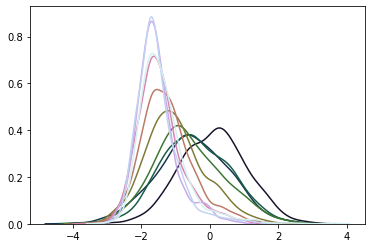

In [182]:
import seaborn as sns
with sns.color_palette("cubehelix",10):
  for epoch in samples[::epochs//10]:
    sns.distplot(epoch[:,0], hist=False)

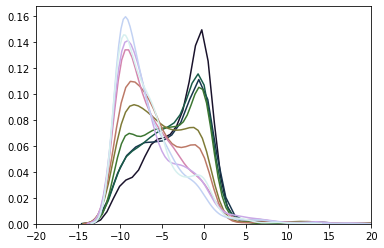

In [17]:
with sns.color_palette("cubehelix",10):
  for epoch in energy_samples[::epochs//10]:
    ax = sns.distplot(epoch[:], hist=False)
    ax.set(xlim=(-20, 20))

In [18]:
logweight

{-12.0: 0,
 -11.5: 0,
 -11.0: -166.05888356385535,
 -10.5: -201.25838587026848,
 -10.0: -199.46973663651386,
 -9.5: -197.6846470237284,
 -9.0: -194.82582309318155,
 -8.5: -190.24446437239044,
 -8.0: -185.65914641682497,
 -7.5: -188.59878362699493,
 -7.0: -187.3256285179143,
 -6.5: -186.28271347365995,
 -6.0: -182.4162771359723,
 -5.5: -177.33552734201157,
 -5.0: -173.78063557767348,
 -4.5: -173.25759317366376,
 -4.0: -171.56731426865448,
 -3.5: -167.35802450075107,
 -3.0: -166.98705338107757,
 -2.5: -165.07367636614654,
 -2.0: -167.86827096935957,
 -1.5: -167.5441391105628,
 -1.0: -172.28529179148867,
 -0.5: -187.87047055256946,
 0.0: -186.5748579565305,
 0.5: -135.86691682997392,
 1.0: -100.77360109948962,
 1.5: -68.97691726585397,
 2.0: -50.7969738819831,
 2.5: -46.54092705016976,
 3.0: -25.6963643582672,
 3.5: -26.835798641455565,
 4.0: -21.25312503942533,
 4.5: -8.435549202375727}

In [19]:
h=np.histogram(energy_samples[0],17*2,range=(-12,5))
hist=dict(zip(h[1],h[0]))

In [ ]:
hist

{-12.0: 0,
 -11.5: 0,
 -11.0: 15,
 -10.5: 18,
 -10.0: 21,
 -9.5: 20,
 -9.0: 19,
 -8.5: 15,
 -8.0: 21,
 -7.5: 30,
 -7.0: 26,
 -6.5: 32,
 -6.0: 29,
 -5.5: 27,
 -5.0: 27,
 -4.5: 44,
 -4.0: 40,
 -3.5: 37,
 -3.0: 47,
 -2.5: 45,
 -2.0: 50,
 -1.5: 63,
 -1.0: 72,
 -0.5: 114,
 0.0: 122,
 0.5: 37,
 1.0: 18,
 1.5: 11,
 2.0: 4,
 2.5: 1,
 3.0: 3,
 3.5: 1,
 4.0: 0,
 4.5: 0}

In [165]:
a=tf.cast(tf.constant(range(100,0,-1)),dtype=tf.float32)

In [166]:
a

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([100.,  99.,  98.,  97.,  96.,  95.,  94.,  93.,  92.,  91.,  90.,
        89.,  88.,  87.,  86.,  85.,  84.,  83.,  82.,  81.,  80.,  79.,
        78.,  77.,  76.,  75.,  74.,  73.,  72.,  71.,  70.,  69.,  68.,
        67.,  66.,  65.,  64.,  63.,  62.,  61.,  60.,  59.,  58.,  57.,
        56.,  55.,  54.,  53.,  52.,  51.,  50.,  49.,  48.,  47.,  46.,
        45.,  44.,  43.,  42.,  41.,  40.,  39.,  38.,  37.,  36.,  35.,
        34.,  33.,  32.,  31.,  30.,  29.,  28.,  27.,  26.,  25.,  24.,
        23.,  22.,  21.,  20.,  19.,  18.,  17.,  16.,  15.,  14.,  13.,
        12.,  11.,  10.,   9.,   8.,   7.,   6.,   5.,   4.,   3.,   2.,
         1.], dtype=float32)>

In [171]:
b=tf.constant([2]*200)

In [172]:
b

<tf.Tensor: shape=(200,), dtype=int32, numpy=
array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2], dtype=int32)>

In [173]:
tf.gather(a,b)

<tf.Tensor: shape=(200,), dtype=float32, numpy=
array([98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98.,
       98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98.,
       98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98.,
       98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98.,
       98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98.,
       98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98.,
       98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98.,
       98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98.,
       98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98.,
       98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98.,
       98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98.,
       98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98.,
       98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98., 98.,
       98., 98.,

In [41]:
tf.cond(a > 0, lambda: tf.math.log(a), lambda: 0)

ValueError: ignored

In [43]:
tf.map_fn(lambda x: tf.math.log(x) if x > 0 else 0, a)

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([0.       , 0.       , 0.6931472, 1.0986123, 1.3862944, 1.609438 ,
       1.7917595, 0.       ], dtype=float32)>